"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
from scipy.stats import beta

(30, 3)
(29, 3)
(30, 4)
(2, 3)
(30, 100)


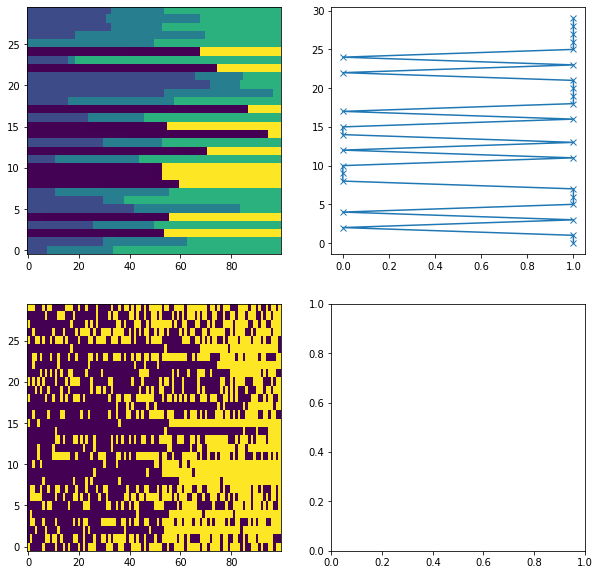

In [2]:
# Some poisson spiking
length = 100
states = 3
trials = 30
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random((trials,states)),axis=-1)
print(true_tau.shape)
true_tau /= np.max(true_tau,axis=-1)[:,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)


state_inds = np.concatenate([np.zeros((trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

n_components = 2
true_lambda = np.random.random((n_components,states))

print(true_tau.shape)
print(state_inds.shape)
print(true_lambda.shape)

component_inds = np.random.choice(range(n_components), trials, p = [0.3,0.7])
true_r = np.zeros((trials,length))
for trial in range(trials):
    for state in range(states):
        true_r[trial, state_inds[trial,state]:state_inds[trial,state+1]] = \
                    true_lambda[component_inds[trial],state]
  
data_vec = np.random.random(true_r.shape) < true_r
print(data_vec.shape)
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,1].plot(component_inds, np.arange(trials),'-x')
ax[0,0].imshow(true_r,aspect='auto',origin='lower')
ax[1,0].imshow(data_vec,aspect='auto',origin='lower')
# ax[1].set_ylabel("True Rate")
# ax[2].set_ylabel("Spikes")

In [3]:
mean_vals = np.array([np.mean(x,axis=(0,-1)) for x in np.array_split(data_vec,states,axis=-1)]).T
print(mean_vals)

[0.23235294 0.41313131 0.67979798]


In [4]:
with pm.Model() as model:

    w = pm.Dirichlet('w', a=np.ones(n_components)*5, shape = (trials,n_components))
    #w = pm.Dirichlet('w', a=np.ones(n_components)*5, shape = n_components)
    #category = pm.Categorical("category", p=w, shape=trials)
    
    alphas = pm.HalfCauchy('alphas',5,shape=(2,3))
    betas = pm.HalfCauchy('betas',5,shape=(2,3))
    clust0_lambda = tt.stack([pm.Beta('l00',alphas[0,0], betas[0,0]),
                             pm.Beta('l01',alphas[0,1], betas[0,1]),
                             pm.Beta('l02',alphas[0,2], betas[0,2])])
    clust1_lambda = tt.stack([pm.Beta('l10',alphas[1,0], betas[1,0]),
                             pm.Beta('l11',alphas[1,1], betas[1,1]),
                             pm.Beta('l12',alphas[1,2], betas[1,2])])
    lambdas = tt.stack([clust0_lambda,clust1_lambda])
    
    #lambda0 = pm.Beta('l00',alphas[0,0], betas[0,0])*w[0] + pm.Beta('l10',alphas[1,0], betas[1,0])*w[1]
    #lambda1 = pm.Beta('l01',alphas[0,1], betas[0,1])*w[0] + pm.Beta('l11',alphas[1,1], betas[1,1])*w[1]
    #lambda2 = pm.Beta('l02',alphas[0,2], betas[0,2])*w[0] + pm.Beta('l12',alphas[1,2], betas[1,2])*w[1]
    #lambdas = tt.stack([lambda0,lambda1,lambda2])
    #components = [[pm.Beta.dist(alphas[comp,state], betas[comp,state]) for comp in range(comps)] for state in range(states)]
    #mixes = tt.stack([pm.Mixture(f'mixes{num}', w=w, comp_dists = this_comp, testval = mean_vals[num]) for num,this_comp in enumerate(components)])

In [12]:
print(w.tag.test_value.shape)
#print(category.tag.test_value)
print(clust0_lambda.tag.test_value)
print(clust1_lambda.tag.test_value)
print(lambdas.tag.test_value.shape)

(30, 2)
[0.5 0.5 0.5]
[0.5 0.5 0.5]
(2, 3)


In [7]:
# print(mixes.tag.test_value.shape)
# print(mixes.tag.test_value)
#print(lambdas.tag.test_value.shape)

In [8]:
with model:   
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [9]:
print(tau.tag.test_value.shape)
print(idx.shape)

(30, 2)
(100,)


In [10]:
with model:   
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis, np.newaxis, :]-tau[:,:,np.newaxis])
    weight_stack_shape = weight_stack.tag.test_value.shape
    weight_stack = tt.concatenate([np.ones((weight_stack_shape[0],1,weight_stack_shape[-1])),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((weight_stack_shape[0],1,weight_stack_shape[-1]))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [11]:
print(weight_stack.tag.test_value.shape)
print(inverse_stack.tag.test_value.shape)

(30, 3, 100)
(30, 3, 100)


In [13]:
#plt.imshow(weight_stack.tag.test_value[1],aspect='auto')

In [14]:
print(w.tag.test_value.shape)
print(lambdas.tag.test_value.shape)

(30, 2)
(2, 3)


In [15]:
with model:
    selected_lambdas = tt.tensordot(w,lambdas,[1,0])[:,:,np.newaxis]
print(selected_lambdas.tag.test_value.shape)

(30, 3, 1)


In [16]:
with model:
    lambda_ = tt.sum(selected_lambdas*weight_stack,axis=1)
    #lambda_ = weight_stack[:,0]*lambda0 + weight_stack[:,1]*lambda1 + weight_stack[:,2]*lambda2
    #lambda_ = tt.tensordot(weight_stack, lambdas, [1,0])
    #lambda_ = mixes.dot(weight_stack)
    #lambda_fin = np.tile(lambda_[np.newaxis,:], (data_vec.shape[0],1))
    

In [17]:
print(lambda_.tag.test_value.shape)

(30, 100)


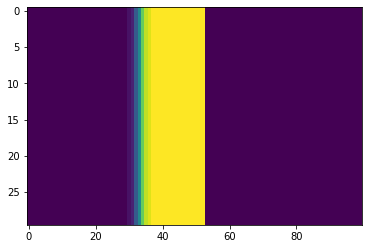

In [18]:
plt.imshow(lambda_.tag.test_value,aspect='auto')

In [19]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

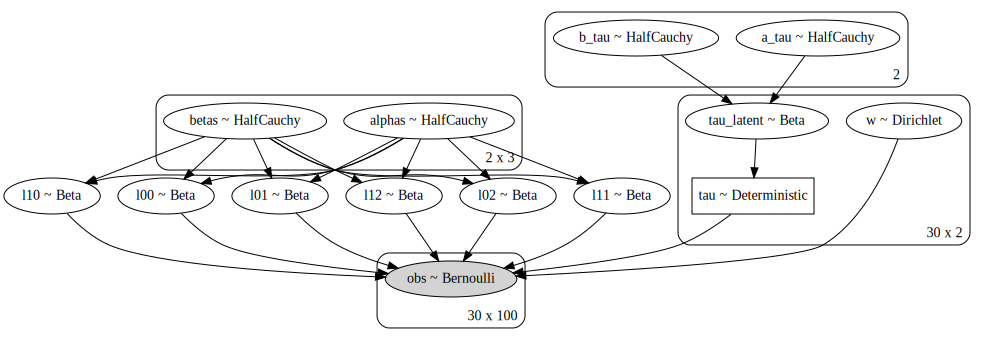

In [20]:
pm.model_to_graphviz(model)

In [40]:
#with model:     
#     #step = pm.Metropolis()
#     step = pm.NUTS()
#     trace = pm.sample(step=step)
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)

  0%|          | 0/100000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 1,658.5: 100%|██████████| 100000/100000 [01:24<00:00, 1180.56it/s]
Finished [100%]: Average Loss = 1,658.4


In [41]:
#pm.traceplot(trace);

In [42]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)

100%|██████████| 2000/2000 [00:04<00:00, 450.88it/s]


In [43]:
ppc_trace['obs'].shape
mean_ppc_obs = np.mean(ppc_trace['obs'],axis=0)

In [44]:
tau_samples = trace['tau']
int_tau = np.vectorize(np.int)(tau_samples)
print(int_tau.shape)
mode_tau = stats.mode(int_tau,axis=0)[0][0]
print(mode_tau.shape)

(2000, 30, 2)
(30, 2)


In [45]:
hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

In [46]:
# cat_samples = trace['category']
# plt.imshow(cat_samples,aspect='auto')
# print(cat_samples.shape)
w_samples = trace['w']
print(w_samples.shape)
mean_w = np.mean(w_samples,axis=0)
categorical_w = np.argmax(mean_w,axis=-1)
print(categorical_w.shape)

(2000, 30, 2)
(30,)


In [47]:
# cat_hist = np.array([np.histogram(trial,bins=np.arange(3))[0] for trial in cat_samples.swapaxes(0,1)])
# #print(cat_hist)

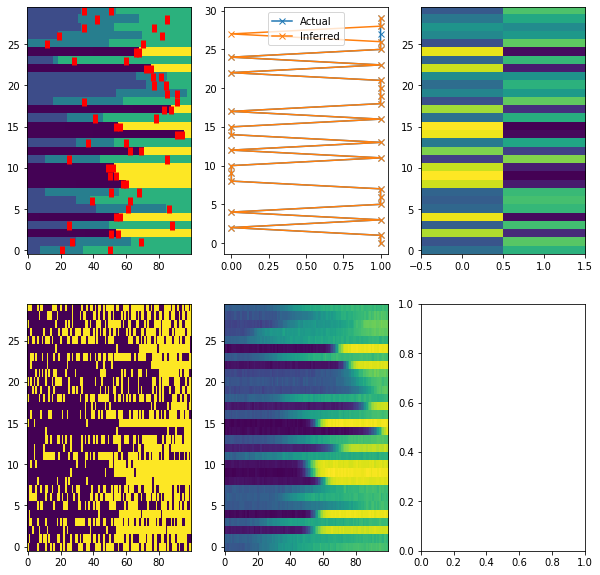

In [49]:
fig,ax = plt.subplots(2,3,figsize=(10,10))
ax[0,1].plot(component_inds, np.arange(trials),'-x',label='Actual')
ax[0,1].plot(categorical_w, np.arange(trials),'-x', label='Inferred')
ax[0,1].legend()
for trial,val in enumerate(mode_tau):
    ax[0,0].vlines(val, trial-0.5,trial+0.5, linewidth = 5, color='red')
ax[0,0].imshow(true_r,aspect='auto',origin='lower')
ax[1,0].imshow(data_vec,aspect='auto',origin='lower')
ax[1,1].imshow(mean_ppc_obs,aspect='auto',origin='lower');
ax[0,2].imshow(mean_w,aspect='auto',origin='lower');

## =============================

## 1D Beta Mixture

In [ ]:
r = np.concatenate([beta.rvs(10, 2, size=1000),beta.rvs(2, 10, size=500)])
plt.hist(r,bins=50);

In [ ]:
comps = 2
with pm.Model() as model:
    w = pm.Dirichlet('w', a=np.ones(comps)*5)
    alphas = pm.HalfCauchy('alphas',5,shape=2)
    betas = pm.HalfCauchy('betas',5,shape=2)
    components = [pm.Beta.dist(alphas[x], betas[x]) for x in range(comps)]
    like = pm.Mixture('like', w=w, comp_dists = components, observed=r)
    trace = pm.sample()

In [ ]:
pm.traceplot(trace);

In [ ]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, var_names=["like"])

In [ ]:
ppc_trace['like'].shape
plt.hist(ppc_trace['like'].flatten(),bins=50);

## =============================

In [ ]:
npop = 5
nd = (1, 2)
with pm.Model() as model:
    mu = pm.Normal('mu', mu=np.arange(npop), sigma=1, shape=npop) # Each component has an independent mean

    w = pm.Dirichlet('w', a=np.ones(npop))

    components = pm.Normal.dist(mu=mu, sigma=1, shape=nd + (npop,))  # nd + (npop,) shaped multinomial

    like = pm.Mixture('like', w=w, comp_dists = components, shape=nd)  # The resulting mixture is nd-shaped
    
    trace = pm.sample(5000, n_init=10000, tune=1000)

In [ ]:
print(like.tag.test_value.shape)

In [ ]:
pm.traceplot(trace);

In [ ]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, var_names=["like"])

In [ ]:
like_ppc = ppc_trace['like']
print(like_ppc.shape)
plt.hist2d(*np.squeeze(like_ppc).T,bins=50);

In [ ]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = (nrns,states),
                                  testval = mean_vals + 1e-3)



In [ ]:
with model:
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [ ]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [ ]:
plt.imshow(weight_stack.tag.test_value,aspect='auto')

In [ ]:
print(weight_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

In [ ]:
with model:
    lambda_ = lambda_latent.dot(weight_stack)

In [ ]:
plt.imshow(true_r,aspect='auto')
plt.figure()
plt.imshow(lambda_.tag.test_value, aspect='auto')
print(lambda_.tag.test_value.shape)

In [ ]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [ ]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

In [ ]:
fig,ax = plt.subplots(2,1,sharey=True)
ax[0].imshow(true_r,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0), aspect='auto')
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')

In [ ]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

In [ ]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,10))
ax[0].imshow(true_r,aspect='auto')
ax[0].set_ylabel('True r')
ax[1].imshow(data_vec,aspect='auto')
    
for tau_num, this_tau in enumerate(tau.T):
    ax[2].hist(this_tau,bins=50)
    ax[0].vlines(mode_tau[tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')
